## Train CNN based on Udacity

This notebook is to debug the outline training the CNN, specifically to ensure that the training data is as expected and the output from a training or testing run can be visualised.

Note that in order to train the CNN, this code will need to be run on GCP (or similar GPU-based server).


### Setup environments

#### Imports

Note that these imports are for the purposes of this notebook, they will be different when running `train.py` or `test.py`

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import Callback, TensorBoard, EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from nn import nn
from nn import data_reader
from tracklets import generate_tracklet


#### Set up environment variables (Mac)

Run this section for training/testing on my Mac

In [4]:
BATCH_SIZE = 1
DATA_DIR = '/vol/didi/dataset2/Tracklets/1/2/'
LOGDIR = '/vol/training/logs'
TRAIN_DIR = '/vol/dataset2/Train/'
PREDICT_DIR = '/vol/dataset2/Predict/'
CSV='data.csv'
CHECKPOINT_EVERY = 100
NUM_STEPS = int(1e2)   # Run for 100 steps
CKPT_FILE = 'model.ckpt'
LEARNING_RATE = 1e-3
KEEP_PROB = 0.8
L2_REG = 0
EPSILON = 0.001
MOMENTUM = 0.9

#### Set up environment variables (GCP)

Run this for training/testing on GCP instance

In [ ]:
BATCH_SIZE = 1
DATA_DIR = '/vol/dataset2/Didi-Release-2/Tracklets/1/2/'
LOGDIR = '/vol/training/logs'
TRAIN_DIR = '/vol/dataset2/Didi-Release-2/Train/'
PREDICT_DIR = '/vol/dataset2/Didi-Release-2/Predict/'
CSV='data.csv'
CHECKPOINT_EVERY = 100
NUM_STEPS = int(1e2)   # Run for 100 steps
CKPT_FILE = 'model.ckpt'
LEARNING_RATE = 1e-3
KEEP_PROB = 0.8
L2_REG = 0
EPSILON = 0.001
MOMENTUM = 0.9

### Setup model

This currently assumes u-net based model configured in nn/nn.py

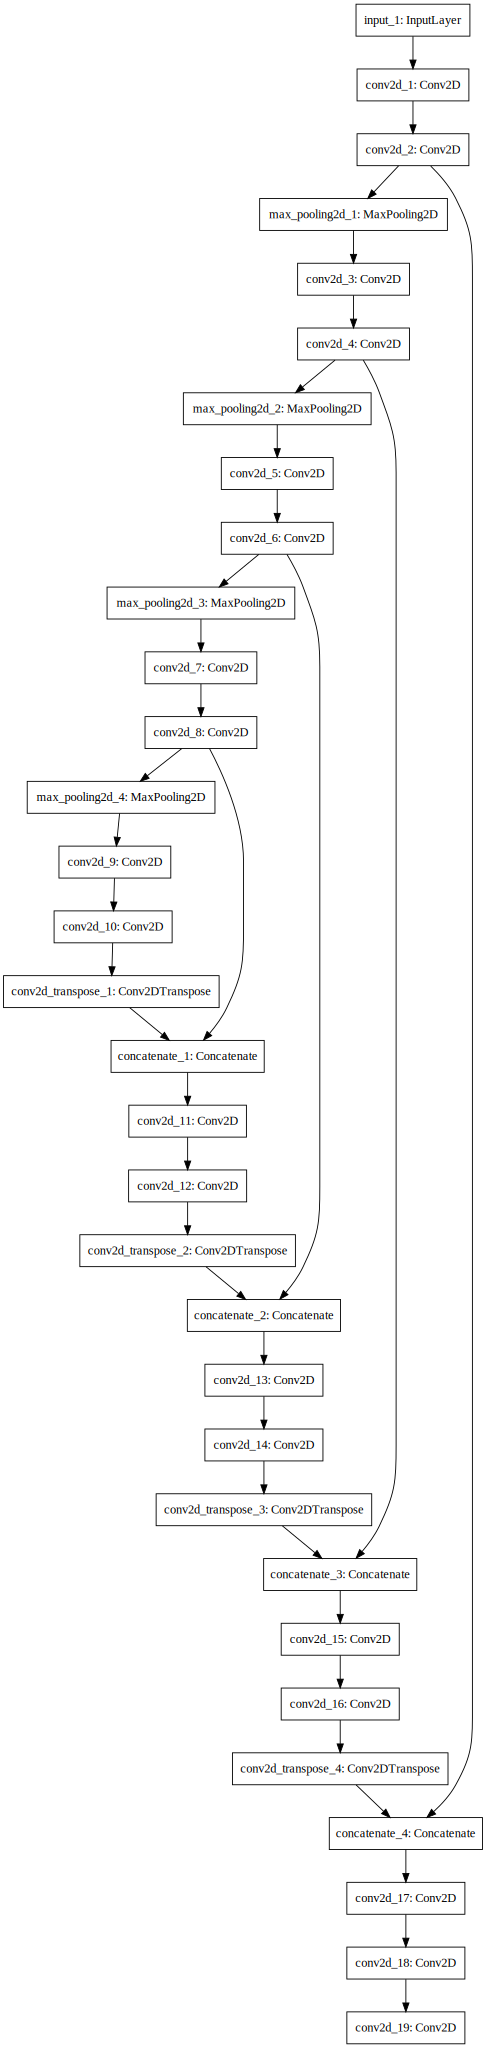

In [5]:
LossHistory, model = nn.top_nn()
# summary = model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Setup data_reader() for loading data

In [6]:
data_reader = data_reader.DataReader(DATA_DIR)

Parsing Tracklet file /vol/didi/dataset2/Tracklets/1/2/tracklet_labels.xml
File contains 1 Tracklets
Loaded 1 Tracklets


Load a single training sample to get things moving

In [7]:
xs, ys = data_reader.load_train_batch(batch_size=BATCH_SIZE)

Display info about the training data:

* xs = `pointcloud.npy` data based on the format created by `sensor_pipeline/extract_pointclouds.py`
* ys = mask of obstacle in (0,1) format, where 0=background and 1=obstacle (car)

In [8]:
print ('xs.shape={}'.format(xs.shape))
print ('ys.shape={}'.format(ys.shape))

xs.shape=(1, 400, 400, 8)
ys.shape=(1, 400, 400, 1)


Render the training mask and the respective point cloud image (generated by `pointcloud_utils/create_pointcloud_image.py`)

In [9]:
pcl_mask=np.array(ys[0,:,:,0], dtype=np.uint8)

In [10]:
#print (pcl_mask)
print (np.nonzero(pcl_mask))
print (pcl_mask[87:132, 184:208])

(array([ 88,  88,  88, ..., 131, 131, 131]), array([185, 186, 187, ..., 205, 206, 207]))
[[0 0 0 ..., 0 0 0]
 [0 1 1 ..., 1 1 1]
 [0 1 1 ..., 1 1 1]
 ..., 
 [0 1 1 ..., 1 1 1]
 [0 1 1 ..., 1 1 1]
 [0 1 1 ..., 1 1 1]]


In [11]:
timestamp = '1490991281474291000'    # First pointcloud in the bag
pointcloud_image_file=os.path.join(DATA_DIR, 'processed', 'lidar_top_img', timestamp + '.png')

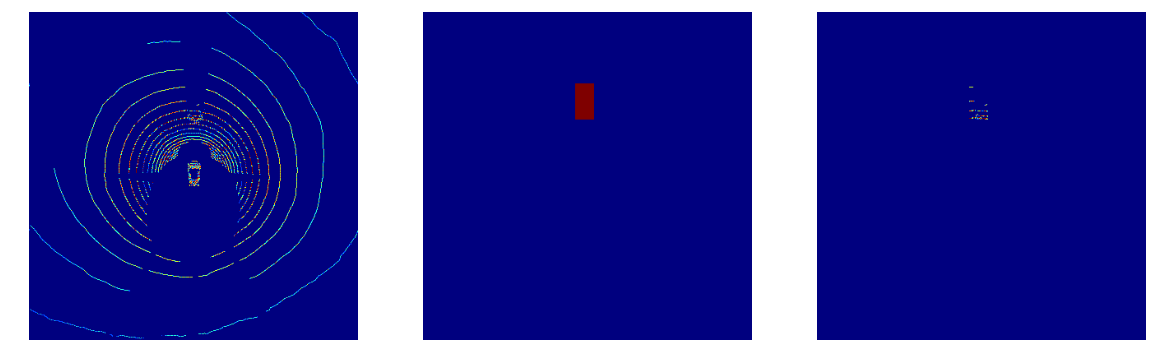

In [31]:
plt.figure(figsize=(20,10))

pcl_image = cv2.imread(pointcloud_image_file,0)
plt.subplot(1,3,1)
plt.axis("off")
plt.imshow(pcl_image)

plt.subplot(1,3,2)
plt.axis("off")
plt.imshow(pcl_mask)

im = np.array(pcl_image,dtype=np.uint8)
im_mask = np.array(pcl_mask,dtype=np.uint8)
plt.subplot(1,3,3)
plt.axis("off")
plt.imshow(cv2.bitwise_and(im,im,mask=im_mask))
plt.show()

# Testing

This section tests the model to see how it performs visually

Load pre-trained weights. Note this filename will change after each training run.

In [23]:
weights='/vol/didi/dataset2/Train/model-final-step-99-val-0.853347.ckpt'
model.load_weights(weights)

Pointcloud to test with:

In [24]:
print (xs.shape)

(1, 400, 400, 8)


In [25]:
predict = model.predict(xs, batch_size = 1)

Investigate output from prediction

In [26]:
print (predict.shape)
predict_image=np.array(255*predict[0,:,:,0], dtype=np.uint8)
print (predict_image.shape)

(1, 400, 400, 1)
(400, 400)


In [29]:
#print (np.nonzero(predict_image))
print (predict_image[87:132, 184:208])
#print (np.argwhere(predict_image>0))

[[  0   0   0 ...,   0   0   0]
 [  0   0   0 ...,   1   0   0]
 [  0   0   0 ..., 221   0   0]
 ..., 
 [  0   0   0 ...,   0   0   0]
 [  0   0   0 ...,   0   0   0]
 [  0   0   0 ...,   0   0   0]]


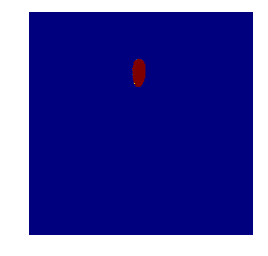

In [30]:
plt.axis("off")
plt.imshow(predict_image)
plt.show()

In [34]:
print pcl_image.shape
print pcl_mask.shape
print predict_image.shape

(400, 400)
(400, 400)
(400, 400)


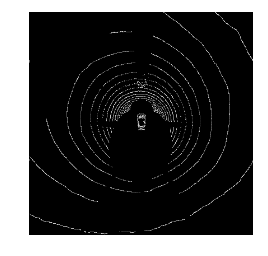

In [47]:
pcl_image_colour = np.zeros((400,400,3))
pcl_image_colour.shape
pcl_image_colour[:,:,0] = pcl_image
pcl_image_colour[:,:,1] = pcl_image
pcl_image_colour[:,:,2] = pcl_image
plt.axis("off")
plt.imshow(pcl_image_colour)
plt.show()

(400, 400, 3)
(400, 400, 3)


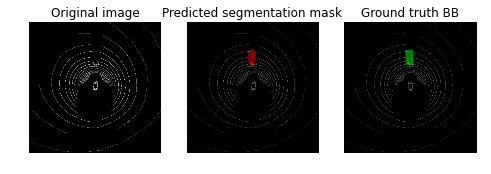

In [56]:
plt.figure(figsize=(100,50))

im = np.array(pcl_image_colour,dtype=np.uint8)
im_mask = np.array(255*pcl_mask,dtype=np.uint8)
im_pred = np.array(predict_image,dtype=np.uint8)
    
rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]
   
print rgb_mask_pred.shape
print rgb_mask_true.shape

img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)
    
plt.figure(figsize=(8,3))
plt.subplot(1,3,1)
plt.imshow(im)
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(img_pred)
plt.title('Predicted segmentation mask')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(img_true)
plt.title('Ground truth BB')
plt.axis('off')
plt.show()

